In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

X = pd.read_csv("FootballPlayerPreparedCleanAttributes.csv").values
y = pd.read_csv("FootballPlayerOneHotEncodedClasses.csv").values  # schon one-hot

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

input_dim = X_train.shape[1]
num_classes = y_train.shape[1]

In [4]:
def build_model(l2_lambda=0.0, dropout_rate=0.0):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

optimizers = {
    "sgd_momentum": tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    "rmsprop": tf.keras.optimizers.RMSprop(learning_rate=0.001),
    "adam": tf.keras.optimizers.Adam(learning_rate=0.001),
}

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

histories = {}

for name, opt in optimizers.items():
    print(f"\n*** Training with {name} ***")
    model = build_model(l2_lambda=0.0, dropout_rate=0.0)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=600,
        batch_size=512,
        callbacks=[early_stop],
        verbose=0
    )
    histories[name] = history
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name}: Test-Loss={test_loss:.4f}, Test-Acc={test_acc:.4f}")


*** Training with sgd_momentum ***
sgd_momentum: Test-Loss=0.3151, Test-Acc=0.8742

*** Training with rmsprop ***
rmsprop: Test-Loss=0.3295, Test-Acc=0.8606

*** Training with adam ***
adam: Test-Loss=0.3199, Test-Acc=0.8643


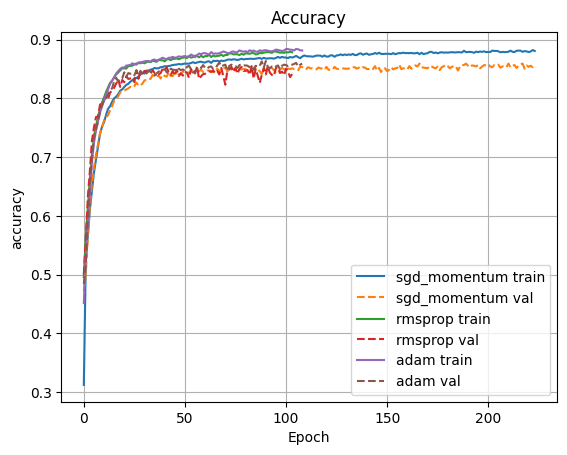

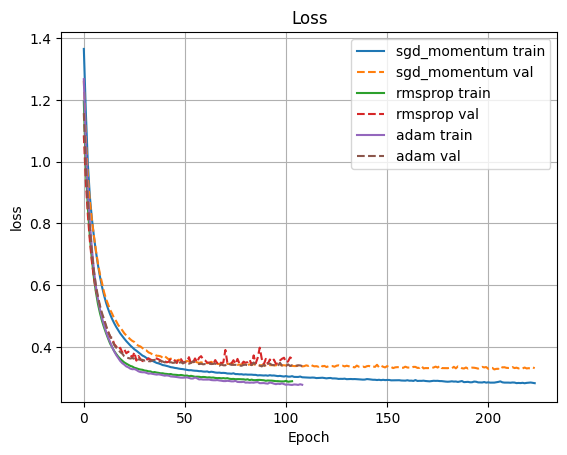

In [5]:
import matplotlib.pyplot as plt

for metric in ["accuracy", "loss"]:
    plt.figure()
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f"{name} train")
        plt.plot(history.history["val_" + metric], linestyle="--", label=f"{name} val")
    plt.title(metric.capitalize())
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

Best Modell (SGD+momentum), Test-Loss=0.3231, Test-Acc=0.8680
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


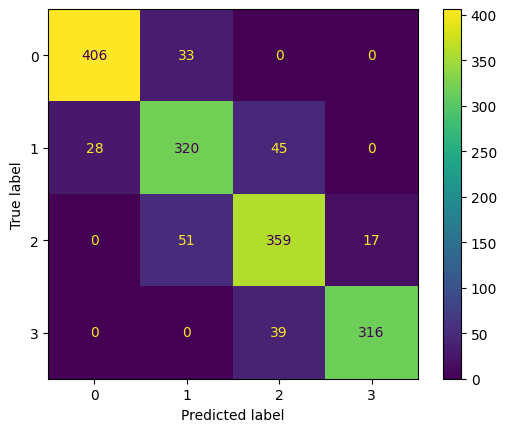

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       439
           1       0.79      0.81      0.80       393
           2       0.81      0.84      0.83       427
           3       0.95      0.89      0.92       355

    accuracy                           0.87      1614
   macro avg       0.87      0.87      0.87      1614
weighted avg       0.87      0.87      0.87      1614



In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

best_opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_best = build_model(l2_lambda=0.0, dropout_rate=0.0)
model_best.compile(optimizer=best_opt,
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

history_best = model_best.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=600,
    batch_size=512,
    callbacks=[early_stop],
    verbose=0
)

test_loss, test_acc = model_best.evaluate(X_test, y_test, verbose=0)
print(f"Best Modell (SGD+momentum), Test-Loss={test_loss:.4f}, Test-Acc={test_acc:.4f}")

# Konfusionsmatrix
y_prob = model_best.predict(X_test)
y_pred = y_prob.argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

print(classification_report(y_true, y_pred))